In [158]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc, fbeta_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [159]:
df = pd.read_csv('data/titanicdf.csv')

## Файл titanicdf.csv, задачи:
1. Предобработать данные (пропуски, замена текста, дубликаты и т.д)
2. Использовать для классификации sklearn.ensemble.RandomForestClassifier
3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)
4. Провести кроссвалидацию модели
5. Оценить метрики бинарной классификации (Precision, recall, f1)
6. Построить ROC-кривую для оценки качества классификатора

### 1. Предобработать данные (пропуски, замена текста, дубликаты и т.д)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [161]:
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [162]:
df.Pclass.value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [163]:
df.Sex.value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [164]:
df.Age.value_counts(normalize=True)

24.00    0.042017
22.00    0.037815
18.00    0.036415
28.00    0.035014
19.00    0.035014
           ...   
55.50    0.001401
74.00    0.001401
0.92     0.001401
70.50    0.001401
12.00    0.001401
Name: Age, Length: 88, dtype: float64

In [166]:
# Находиим дубликаты
df.duplicated().sum()

0

In [167]:
df = df[['Survived','Pclass','Sex','Age','Fare']]

In [168]:
df.fillna(df.Age.median(),inplace = True)

In [169]:
le = LabelEncoder()

In [170]:
df['Sex'] = le.fit_transform(df['Sex'])
df['Sex'] 

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

### 2. Использовать для классификации sklearn.ensemble.RandomForestClassifier

In [171]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived',axis=1), df['Survived'], test_size=0.25, random_state=2)

In [172]:
X_train.head()

,Pclass,Sex,Age,Fare
199,2,0,24.0,13.000
129,3,1,45.0,6.975
90,3,1,29.0,8.050
230,1,0,35.0,83.475
126,3,1,28.0,7.750


In [175]:
clf = RandomForestClassifier()

In [176]:
model = clf.fit(X_train, y_train)
pred = model.predict(X_test)

### 3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)

In [177]:
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
             'n_estimators':[1,5,10,15,20,30,50]}

In [178]:
tree_para

{'criterion': ['gini', 'entropy'],
 'max_depth': [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  15,
  20,
  30,
  40,
  50,
  70,
  90,
  120,
  150],
 'n_estimators': [1, 5, 10, 15, 20, 30, 50]}

In [179]:
clf_gs = GridSearchCV(RandomForestClassifier(), tree_para, cv=10, scoring = 'recall')
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'n_estimators': [1, 5, 10, 15, 20, 30, 50]},
             scoring='recall')

In [180]:
clf_gs.best_params_

{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 15}

In [181]:
model_new = RandomForestClassifier(**clf_gs.best_params_)

In [182]:
model_new.fit(X_train,y_train)

RandomForestClassifier(max_depth=30, n_estimators=15)

In [216]:
new_pred = model_new.predict(X_test)

In [217]:
print('Accuracy:',accuracy_score(y_test,new_pred))
print('Precision:',precision_score(y_test,new_pred))
print('Recall:',recall_score(y_test,new_pred))
print('F1:',f1_score(y_test,new_pred))

Accuracy: 0.7982062780269058
Precision: 0.7582417582417582
Recall: 0.75
F1: 0.7540983606557377


### 4. Провести кроссвалидацию модели

In [234]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
scores = cross_val_score(model_new, X_train, y_train, cv=cv, scoring='recall')

In [235]:
scores.mean()

0.6960999269740953

In [236]:
scores

array([0.68965517, 0.70175439, 0.81481481, 0.77966102, 0.58064516,
       0.71428571, 0.65333333, 0.57377049, 0.72580645, 0.72727273])

### 5. Оценить метрики бинарной классификации (Precision, recall, f1)

In [221]:
print('Accuracy:',accuracy_score(y_test,pred))
print('Precision:',precision_score(y_test,pred))
print('Recall:',recall_score(y_test,pred))
print('F1:',f1_score(y_test,pred))

Accuracy: 0.7847533632286996
Precision: 0.75
Recall: 0.717391304347826
F1: 0.7333333333333332


### 6. Построить ROC-кривую для оценки качества классификатора

In [226]:
model.predict(X_test)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1])

In [227]:
model.predict_proba(X_test)[:,1]

array([0.54666667, 0.        , 0.99      , 0.09      , 0.5       ,
       0.07      , 0.02      , 0.01      , 0.1       , 0.03      ,
       0.1       , 1.        , 0.83      , 0.09      , 0.09      ,
       0.61      , 0.66      , 0.19      , 0.11      , 0.08      ,
       0.63      , 0.73      , 0.175     , 0.05      , 0.1       ,
       1.        , 0.85      , 0.54      , 0.16      , 0.2325    ,
       0.62      , 0.2       , 0.54      , 0.05      , 0.33666667,
       0.95      , 1.        , 0.57      , 0.        , 0.06166667,
       0.        , 0.03      , 0.87271429, 0.07      , 0.02      ,
       0.02      , 0.99      , 0.24      , 0.03      , 0.84166667,
       0.        , 0.57833333, 0.03      , 0.07      , 0.25      ,
       0.13      , 0.03      , 0.01      , 0.        , 0.567     ,
       0.83      , 0.7       , 0.02      , 0.00291667, 0.84      ,
       0.27      , 0.98      , 0.54      , 0.57      , 0.        ,
       0.89      , 0.08      , 0.02      , 0.00394444, 0.69   

In [229]:
pred_proba = model.predict_proba(X_test)[:,1]

In [230]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba)
tree_auc = roc_auc_score(y_test, pred_proba)
print('RandomForestClassifier: ROC AUC=%.3f' % (tree_auc))

RandomForestClassifier: ROC AUC=0.843


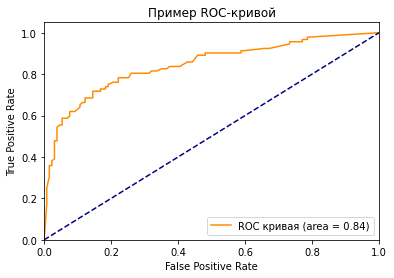

In [231]:
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr,  color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [233]:
treshold

array([2.00000000e+00, 1.00000000e+00, 9.90000000e-01, 9.80000000e-01,
       9.70000000e-01, 9.60000000e-01, 9.50000000e-01, 9.26666667e-01,
       9.20000000e-01, 8.41666667e-01, 8.40000000e-01, 8.30000000e-01,
       8.00000000e-01, 7.80000000e-01, 7.60000000e-01, 7.45992258e-01,
       7.30000000e-01, 7.02500000e-01, 7.00000000e-01, 6.80000000e-01,
       6.70000000e-01, 6.60000000e-01, 6.50000000e-01, 6.30000000e-01,
       6.20000000e-01, 5.78333333e-01, 5.70000000e-01, 5.67000000e-01,
       5.60000000e-01, 5.46666667e-01, 5.40000000e-01, 5.00000000e-01,
       4.70000000e-01, 4.66833333e-01, 4.60000000e-01, 4.40000000e-01,
       4.10000000e-01, 3.50000000e-01, 3.36666667e-01, 2.70000000e-01,
       2.60000000e-01, 2.50000000e-01, 2.40000000e-01, 2.32500000e-01,
       2.00000000e-01, 1.90000000e-01, 1.75000000e-01, 1.60000000e-01,
       1.50000000e-01, 1.30000000e-01, 1.10000000e-01, 1.00000000e-01,
       9.40000000e-02, 9.00000000e-02, 8.00000000e-02, 7.43787972e-02,
      